# Multivariate-Time Series (MTS) Aware Manifold Forests 


References
----------

Visual Examples of Contiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.saama.com%2Fdifferent-kinds-convolutional-filters%2F&psig=AOvVaw1KSgQ0V39eN9S_JB6JAoGc&ust=1584819248892000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMCO4_rlqegCFQAAAAAdAAAAABAD

Visual Examples of Discontiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.mdpi.com%2F2076-3417%2F10%2F5%2F1727%2Fhtm&psig=AOvVaw39o_oj3W8Lkbn-Pq6nbboy&ust=1584819310634000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNDuj5TmqegCFQAAAAAdAAAAABAD

In [1]:
cd ../../

/Users/adam2392/Documents/motor-decoding


In [2]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# evaluation classifier
from rerf.rerfClassifier import rerfClassifier

import sys
print(sys.version)

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

3.8.5 | packaged by conda-forge | (default, Jul 22 2020, 17:24:51) 
[Clang 10.0.0 ]


In [3]:
from mtsmorf.sim.simulate import generate_redundant_data

In [4]:
seed = 12345

In [50]:
def sprandsym(n, density):
    from scipy import stats
    from scipy import sparse
    
    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

# Simulate Data

In [69]:
# length of data sequence
ns = np.array([
    50,
    100,200, 400,1000
])

# assume you can train on half trials and
# test on half the trials
test_size = 0.5

# number of samples
n_samples = 100

# simulated data parameters
n_trials = 100

# dimensionality of data and noise
data_dim = 3
noise_dim = 3
n_chs = data_dim + noise_dim

# data mean vector
mu = np.zeros((data_dim, ))

# permutation strategy
permutation_strategy = 'alternate'

In [70]:
# initialize data structures for train/test data
X_train = np.empty(shape=(0, n_chs, n_trials))
Y_train = np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0, n_chs, n_trials)), np.empty(shape=(0))

# cov2 = sprandsym(3, 0.5).toarray()
# cov1 = np.diag(np.diagonal(cov2))
# first class
cov1 = np.array([
    [1.5, 0, 0],
    [0, 1.25, 0],
    [0, 0, 1.25]
])

# second class
cov2 = np.array([
    [1.5, 1, 1],
    [1, 1.25, 1],
    [1, 1, 1.25]
])

off_diag_idx = np.where(~np.eye(cov2.shape[0],dtype=bool))
snr_factor = 0.9
cov2[off_diag_idx] *= snr_factor

print(cov1)
print(cov2)

# simulate over varying sizes of data sequence
for n_trials in  ns:
    y = []
    X = []
    
    # generate correlated multi-variate time series
    for i in range(n_trials):        
        _x = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples,
                                     mu=mu, cov=cov1,
                                    permutation_strategy=permutation_strategy)
        X.append(_x)
        y.append(0)
    for i in range(n_trials):
        _x = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples, 
                                     mu=mu, cov=cov2,
                                    permutation_strategy=permutation_strategy)

        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)
    
    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=42)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print("Data shape for training and testing: ", X_train.shape, Y_train.shape, X_test.shape)

[[1.5  0.   0.  ]
 [0.   1.25 0.  ]
 [0.   0.   1.25]]
[[1.5  0.9  0.9 ]
 [0.9  1.25 0.9 ]
 [0.9  0.9  1.25]]
Data shape for training and testing:  (1750, 600) (1750,) (1750, 600)


In [34]:
# visualize each class with one sample
xsample0 = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples,
                                     mu=mu, cov=cov1,
                                    permutation_strategy=permutation_strategy)
xsample1 = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples,
                                     mu=mu, cov=cov1,
                                    permutation_strategy=permutation_strategy)

<AxesSubplot:>

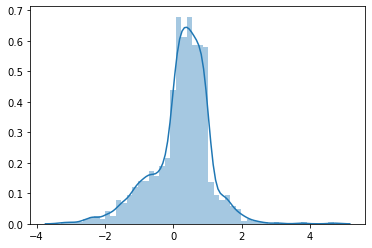

In [10]:
sns.distplot(np.vstack((xsample0, xsample1)))

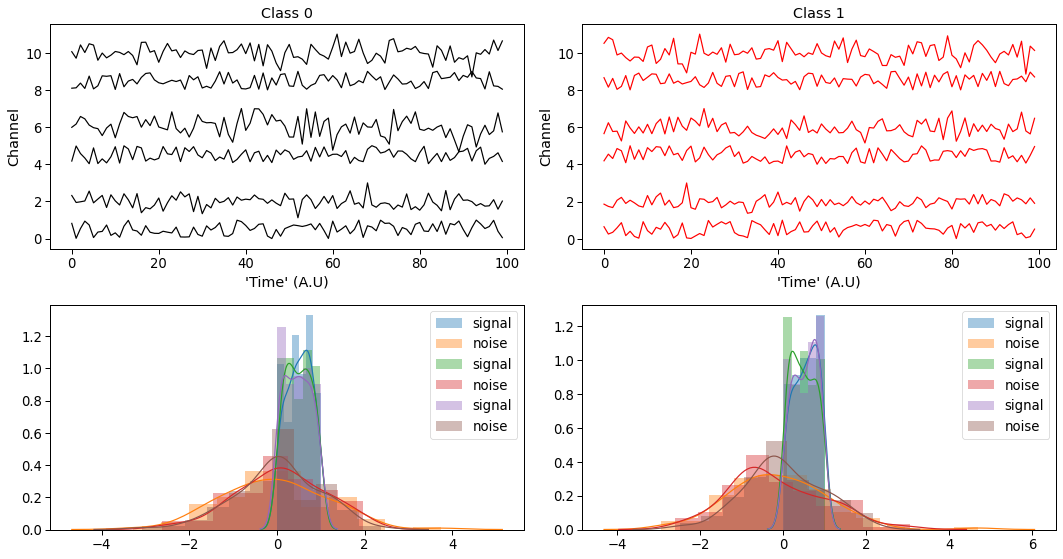

In [11]:
sns.set_context("paper", font_scale=1.5)
fig, axs = plt.subplots(2,2,figsize=(15,8))
axs = axs.flat
ax = axs[0]
prev_max = 0
for i in range(len(xsample0)):
    y = xsample0[i, :]
    ax.plot(2*np.r_[i] + y/np.max(y), 'k', label='class 0')
    prev_max += np.max(y)
ax.set_title("Class 0")
ax.set_ylabel("Channel")
ax.set_xlabel("'Time' (A.U)")

ax = axs[1]
prev_max = 0
for i in range(len(xsample1)):
    y = xsample1[i, :]
    ax.plot(2*np.r_[i] + y/np.max(y), 'r', label='class 1')
    prev_max += np.max(y)
ax.set_title("Class 1")
ax.set_ylabel("Channel")
ax.set_xlabel("'Time' (A.U)")

ax = axs[2]
for i in range(len(xsample0)):
    y = xsample0[i, :]
    if i % 2 != 0:
        label = 'noise'
    else:
        label = 'signal'
    sns.distplot(y, ax=ax, label=label)
ax.legend()

ax = axs[3]
for i in range(len(xsample1)):
    y = xsample1[i, :]
    if i % 2 != 0:
        label = 'noise'
    else:
        label = 'signal'
    sns.distplot(y, ax=ax, label=label)
ax.legend()

fig.tight_layout()

# Compare Classifications

In [71]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", 
         "S-RerF":"red", "MT-MORF": "orange"
        }

ncores=-1
num_runs=1
n_est = 100  # number of estimators

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(n_est, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=n_chs,
                    image_width=n_samples,
                    patch_height_max=2,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   ),
    rerfClassifier(projection_matrix="MT-MORF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=n_chs,
                    image_width=n_samples,
                    patch_height_max=2,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=5
                   )
    ]

In [72]:
runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]
print(f"About to run {len(runList)} clf experiments: "
      f"sample size: {n_samples}, number channels: {n_chs}, "
      f"n_trials: {n_trials}, noise dim: {noise_dim}")

About to run 40 clf experiments: sample size: 100, number channels: 6, n_trials: 1000, noise dim: 3


In [73]:
# Train each classifier on each dataset size, then test
# Prep output file:
fname = f'./mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv'
f = open(fname, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()


for n, clf, iteration in tqdm(runList):
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]
    
    # training start time and end time
    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    # testing start time and end time
    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime
    
    # mean-error on the test set
    lhat = np.mean(np.not_equal(out, Y_test).astype(int))
    ####("variable,Lhat,trainTime,testTime,iterate")
    
    clf_id = clf[1]
    outputstr_row = f"{clf_id}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
    f.write(outputstr_row)
    f.flush()
    
f.close()

100%|██████████| 40/40 [00:16<00:00,  2.37it/s]


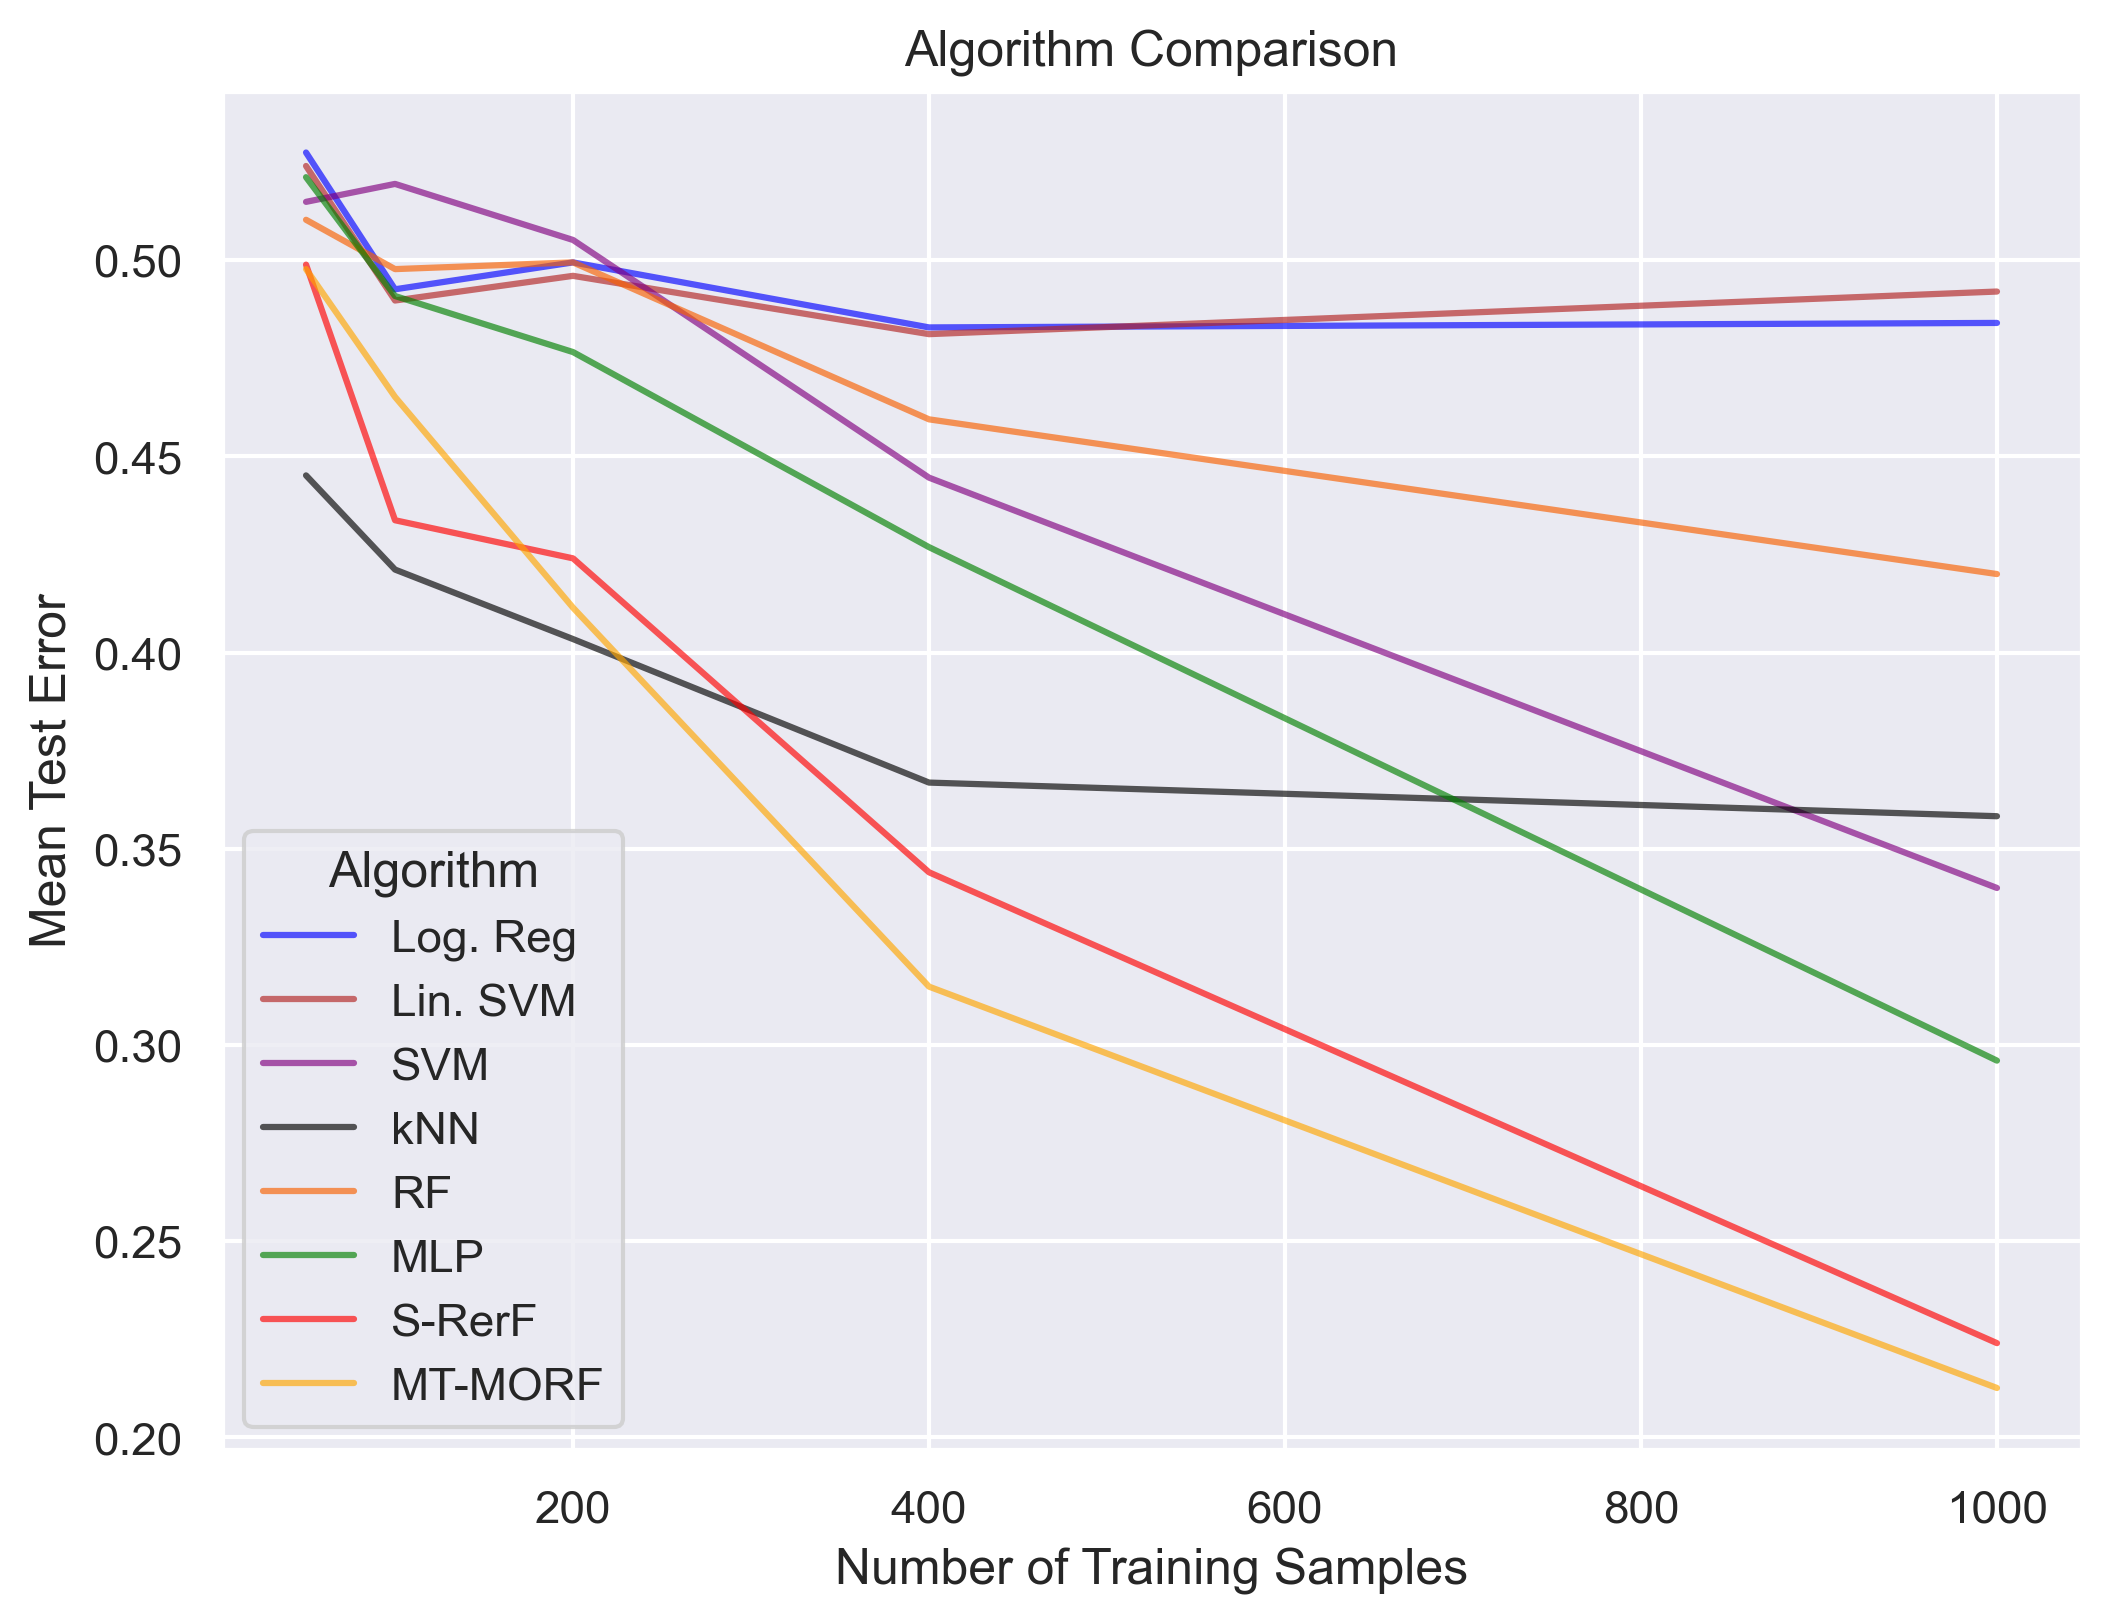

In [74]:
dat = pd.read_csv(fname)
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()

# Compare Classifications on Increasing Noise Dimensionality

In [80]:
def generate_train_test(noise_dim, n_samples, n_chs, n_trials, 
                        mu, cov1, cov2, indices=None, snr_factor=1):
    # make sure dimensionality is integer
    noise_dim = int(noise_dim)
        
    # initialize data structures for train/test data
    X_train = np.empty(shape=(0, n_chs, n_trials))
    Y_train = np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0, n_chs, n_trials)), np.empty(shape=(0))

    y = []
    X = []
    
#     mu = np.array([  0.05, 0.1, 0.2])
    mu = np.zeros((3,))
    # first class
    cov1 = np.array([
        [1.5, 0, 0],
        [0, 1.25, 0],
        [0, 0, 1.25]
    ])

    # second class
    cov2 = np.array([
        [1.5, 1, 1],
        [1, 1.25, 1],
        [1, 1, 1.25]
    ])

    off_diag_idx = np.where(~np.eye(cov2.shape[0],dtype=bool))
    cov2[off_diag_idx] *= snr_factor
    
    # generate correlated multi-variate time series
    for i in range(n_trials):        
        _x = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples,
                                     mu=mu, cov=cov1,
                                     permutation_strategy=permutation_strategy,
                                    indices=indices)
        X.append(_x)
        y.append(0)
    for i in range(n_trials):
        _x = generate_redundant_data(noise_dim=noise_dim,
                                     n_samples=n_samples, 
                                     mu=mu, cov=cov2,
                                    permutation_strategy=permutation_strategy,
                                    indices=indices)

        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)

    # perform training test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=42)
#     X_train = np.vstack((X_train, _X_train))
#     Y_train = np.hstack((Y_train, _y_train))
#     X_test = np.vstack((X_test, _X_test))
#     Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, y_train, X_test, y_test

In [81]:
permutation_strategy = 'random'
snr_factor = 0.5

In [82]:
noise_dims = np.linspace(3, 30, 10)

xtrain, ytrain = [], []
xtest, ytest = [], []
for noise_dim in noise_dims:
    n_trials = 500
    n_chs = int(data_dim + noise_dim)
    
    indices = np.random.choice(np.arange(n_chs), size=n_chs, replace=False)
    assert len(np.unique(indices)) == n_chs
    X_train, Y_train, X_test, Y_test = generate_train_test(
        noise_dim, n_samples, n_chs, n_trials, mu, cov1, cov2,
        indices=indices, snr_factor=snr_factor,
    )
    xtrain.append(X_train)
    ytrain.append(Y_train)
    xtest.append(X_test)
    ytest.append(Y_test)

In [81]:
runList = [(n, run) for n in noise_dims\
#                    for clf in zip(classifiers, 
#                                   [key for key in names])\
                   for run in range(num_runs)]
print(f"About to run {len(runList)} clf experiments: "
      f"sample size: {n_samples}, number channels: {n_chs}, "
      f"n_trials: {n_trials}, noise dim: {noise_dim}")

# Train each classifier on each dataset size, then test
# Prep output file:
fname = f'./mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dims}.csv'
f = open(fname, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()


for jdx, (n, iteration) in enumerate(tqdm(runList)):
    idx = int(np.argwhere(noise_dims == n))
    n_chs = int(data_dim + n)
    
    ## Setup for run
    names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
              "kNN": "black", "RF":"#f86000", "MLP":"green", 
             "S-RerF":"red", "MT-MORF": "orange"
            }

    ncores=-1
    num_runs=1
    n_est = 500  # number of estimators / hidden layers

    classifiers = [
        LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
        LinearSVC(),
        SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
        KNeighborsClassifier(3, n_jobs=ncores),
        RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
        MLPClassifier(hidden_layer_sizes=(n_est, ), random_state=0, max_iter=1000),
        rerfClassifier(projection_matrix="S-RerF",
                       max_features='auto',
                       n_jobs=ncores,
                        n_estimators=n_est,
                        oob_score=False,
                        random_state=0,
                        image_height=n_chs,
                        image_width=n_samples,
                        patch_height_max=3,
                        patch_height_min=1,
                        patch_width_max=20,
                        patch_width_min=5
                       ),
        rerfClassifier(projection_matrix="MT-MORF",
                       max_features='auto',
                       n_jobs=ncores,
                        n_estimators=n_est,
                        oob_score=False,
                        random_state=0,
                        image_height=n_chs,
                        image_width=n_samples,
                        patch_height_max=3,
                        patch_height_min=1,
                        patch_width_max=20,
                        patch_width_min=5
                       )
        ]
    
    for clf in zip(classifiers, [key for key in names]):
        X = xtrain[idx]# .flatten()
        y = ytrain[idx]#.flatten()
        Y_test = ytest[idx]#.flatten()
        X_test = xtest[idx]#.flatten()
    #     X = X_train[:n]
    #     y = Y_train[:n]

        # training start time and end time
        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        # testing start time and end time
        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        # mean-error on the test set
        lhat = np.mean(np.not_equal(out, Y_test).astype(int))
        ####("variable,Lhat,trainTime,testTime,iterate")

        clf_id = clf[1]
        outputstr_row = f"{clf_id}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
        f.write(outputstr_row)
        f.flush()
f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

About to run 10 clf experiments: sample size: 100, number channels: 33, n_trials: 500, noise dim: 30.0


100%|██████████| 10/10 [03:04<00:00, 18.43s/it]


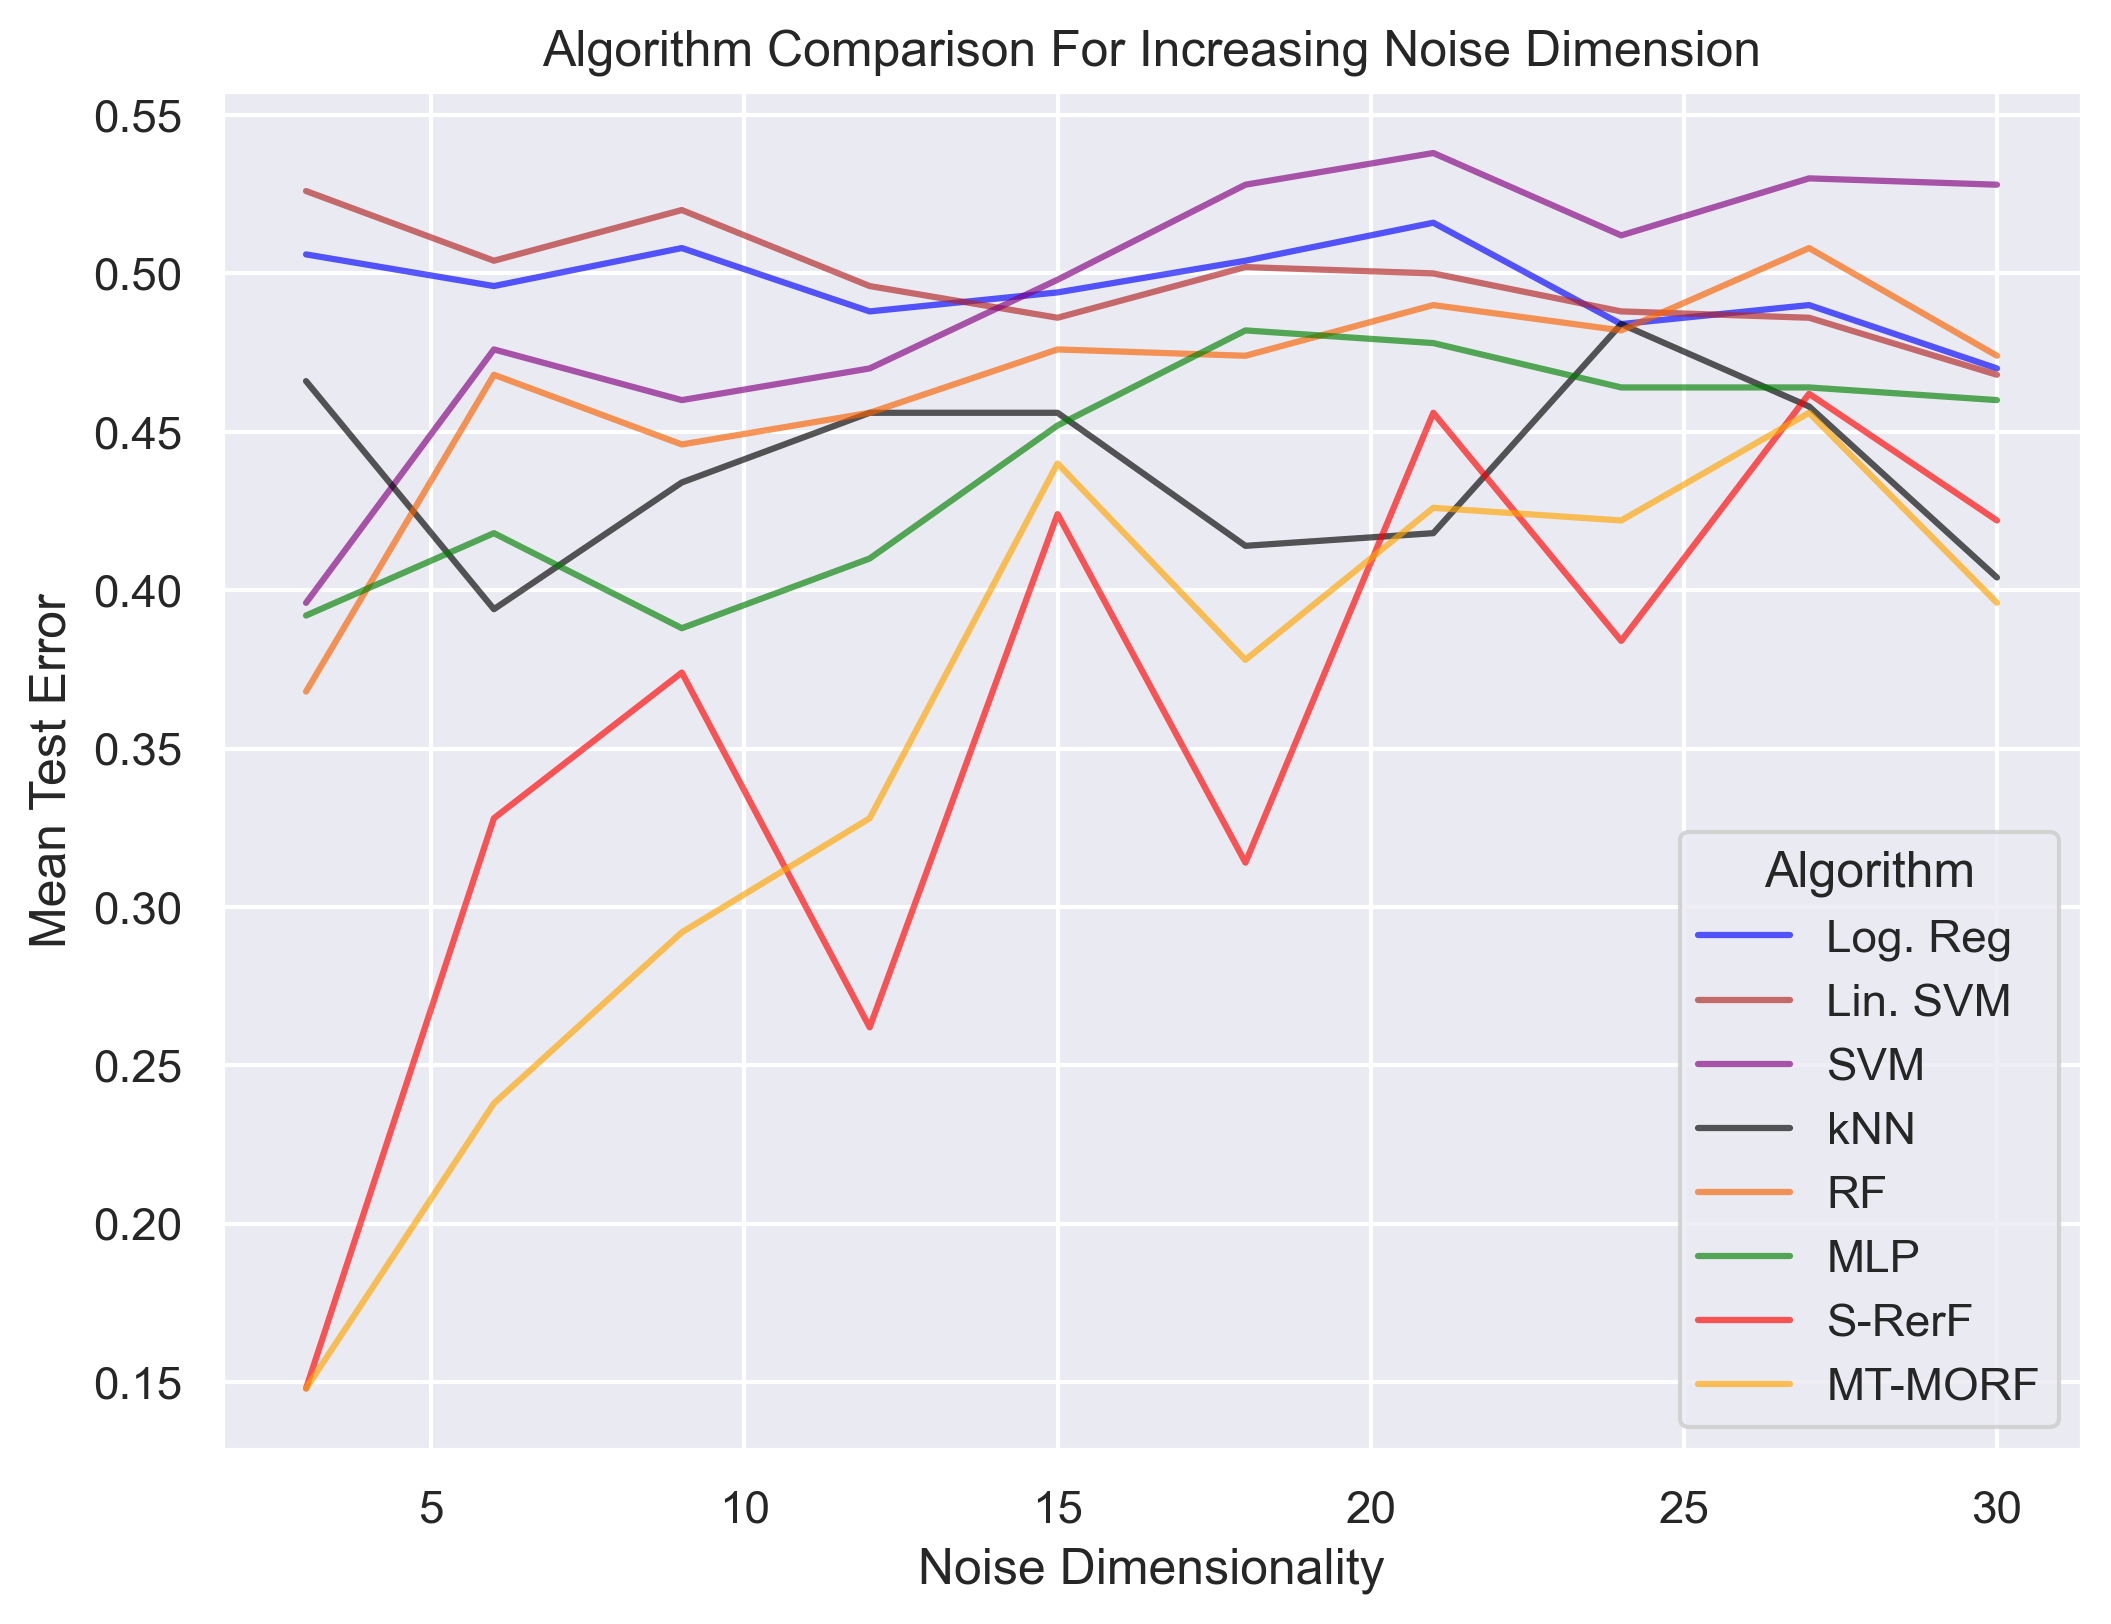

In [82]:
dat = pd.read_csv(fname)
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):
        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison For Increasing Noise Dimension')
plt.ylabel('Mean Test Error')
plt.xlabel('Noise Dimensionality')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()